In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class LWFA():
    
    def __init__(self,z0,omega=2):
        
        D = {}
        D['e'] = 1
        D['m'] = 1
        D['omega'] = omega
        D['omega_0'] = 1
        D['k'] = 1
        D['z0'] = z0
        D['x'] = 0
        self.D = D

    def x(self,E,t,z):
        
        D = self.D
        
        w = D['omega']
        w0 = D['omega_0']
        
        x = D['e']/(D['m']*(w**2-w0**2)) * E
        
        return x

From source [sp mangels] we find that the wave packets they used had a width of 35 fs. Knowing this we construct a wave packet with width of sigma_z = c*tou ( tou = 35 fs)

to encapsulate the entire region we extend the width of the entire region to 6 sigma to hold ~ 99.7% attentuation

In [3]:
class region():
    def __init__(self,name,N = 50):
        self.name = name
        self.width = 6 * 3*10**8 * 35*10**(-15)
        self.N = N
        self.dz = self.width / self.N
        self.c = 3*10**8
        
        # establish a list of electrons, append N electrons and update their positions
        self.electrons = []
        [self.electrons.append(LWFA(-self.width/2 + self.dz * i)) for i in np.arange(self.N)]
        [self.electrons[i].x(0,0,self.dz * i) for i in np.arange(self.N)] #calculate electron positions
        self.positions = -self.width/2.0 + self.dz * np.arange(self.N)  #create a vector holding the positions of all the electrons
        self.amplitudes = np.zeros(self.N)   #creates an amplitude storage vector
        
        #establish the 'amplitude' of positive ions (they're in the same orginal places as the electons)
        self.proton_amp = np.zeros(self.N)
        
    def wave(self,w,z,t):
        sigma = self.c * 35*10**(-15)
        exponent = z**2 / (2 * sigma**2)
        E = np.exp(-exponent)*np.cos(w*(z - t))
        return E
    
    def update_x(self):
        for i in np.arange(self.N):
            z = self.positions[i]
            t = 0
            w = np.linspace(-np.pi/2,np.pi/2,3)
            E = 0
            for j in w:
                E += self.wave(j,z,t)
            self.amplitudes[i] =(-1)**i * self.electrons[i].x(E,t,z)
            


In [4]:
region1 = region('region1')
region1.update_x()

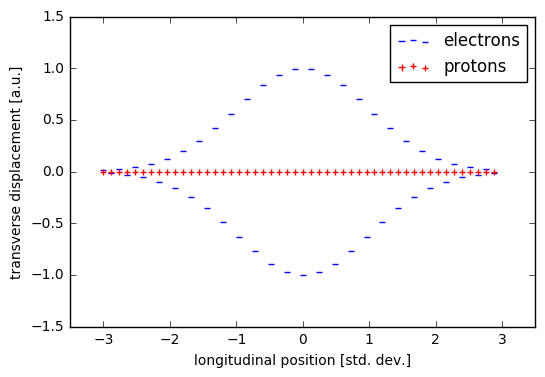

In [5]:
fig = plt.figure('charge dist')
hold = True
sigma = region1.c * 35*10**(-15)
plt.xlim([-3.5,3.5])
plt.scatter(region1.positions/sigma, region1.amplitudes, color='b', marker='_', label = 'electrons')
plt.scatter(region1.positions/sigma, region1.proton_amp, color='r', marker='+', label = 'protons')
plt.legend()
plt.ylabel('transverse displacement [a.u.]')
plt.xlabel('longitudinal position [std. dev.]')
plt.show()

The plot above represents the distribution of electrons for a gaussian wave packet that has been fully immersed in the plasma. This snapshot in time displaces the amplitude of displacement for electrons placed along the z-axis at x = 0

In [38]:
xvec = np.linspace(-3,3,100);
yvec = np.linspace(-1.5,1.5,100);

XX, YY = np.meshgrid(xvec,yvec);
FX = np.zeros(np.shape(XX))
FY = np.zeros(np.shape(YY))
N = region1.N
e_pos = [region1.positions,region1.amplitudes]
p_pos = [region1.positions,np.zeros(len(region1.positions))]

In [39]:
def fforce(pos1,pos2):
    x1 = pos1[0]
    y1 = pos1[1]
    x2 = pos2[0]
    y2 = pos2[1]
    
    dx = x2 - x1
    dy = y2 - y1
    
    r = (dx**2 + dy**2)**(1/2)
    
    fx = dx / r**3
    fy = dy / r**3
    
    return np.array([fx,fy])
    

In [40]:
for i in np.arange(100):
    for j in np.arange(100):
        gridpos = [XX[i,j],YY[i,j]]
        for t in np.arange(N):
            particle = [e_pos[0][t],e_pos[1][t]]
            force = -fforce(particle,gridpos)
            FX[i,j] += force[0]
            FY[i,j] += force[1]
        for t in np.arange(N):
            particle = [p_pos[0][t],p_pos[1][t]]
            force = fforce(particle,gridpos)
            FX[i,j] += force[0]
            FY[i,j] += force[1]


In [56]:
def main():
    sigma = region1.c * 35*10**(-15)
    #########
    N = region1.N
    res = 100
    xvec = np.linspace(region1.positions[0]/sigma,region1.positions[N-1]/sigma,res);
    yvec = np.linspace(-1.5,1.5,res);
    
    XX, YY = np.meshgrid(xvec,yvec);
    FX = np.zeros(np.shape(XX))
    FY = np.zeros(np.shape(YY))
    zero_mat = np.zeros(np.shape(YY))
    e_pos = [region1.positions/sigma,region1.amplitudes/sigma]
    p_pos = [region1.positions/sigma,np.zeros(len(region1.positions))]
             
    def fforce(pos1,pos2):
        x1 = pos1[0]
        y1 = pos1[1]
        x2 = pos2[0]
        y2 = pos2[1]
        
        dx = x2 - x1
        dy = y2 - y1
        
        r = (dx**2 + dy**2)**(1/2)
        
        fx = dx / r**3
        fy = dy / r**3
        
        if dx == 0:
            fx = 0
        elif dy == 0:
            fy = 0
        else:
            pass
        
        return np.array([fx,fy])
        
    for i in np.arange(res):
        for j in np.arange(res):
            gridpos = [XX[i,j],YY[i,j]]
            for t in np.arange(N):
                particle = [e_pos[0][t],e_pos[1][t]]
                force = fforce(particle,gridpos)
                FX[i,j] += force[0]
                FY[i,j] += force[1]
            for t in np.arange(N):
                particle = [p_pos[0][t],p_pos[1][t]]
                force = -fforce(particle,gridpos)
                FX[i,j] += force[0]
                FY[i,j] += force[1]
    return FX,FY,XX,YY,xvec,yvec

In [65]:
def plot(FX,FY,XX,YY,xvec,yvec):
    res=100
    fontsize = 12
    lw = 3
    zero_mat = np.zeros(np.shape(YY))
    skip = (slice(None,None,4),slice(None,None,4))
    plt.figure(str(res)+' resolution, FX and FY')
    
    plt.xlim([-3.5,3.5])
    plt.scatter(region1.positions/sigma, region1.amplitudes, color='b', marker='o', label = 'electrons',linewidth=lw)
    plt.scatter(region1.positions/sigma, region1.proton_amp, color='r', marker='o', label = 'protons',linewidth=lw)
    
    hold = True
    
    plt.quiver(xvec,yvec,FX,FY,scale=20000,pivot='mid',alpha = 0.25,label = 'Electric Field')
    plt.xlim([-3.5,3.5])
    plt.ylim([-1.5,1.5])
    plt.ylabel('transverse displacement [a.u.]',fontsize=fontsize)
    plt.xlabel('longitudinal position [std. dev.]',fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()
    
    FXY = plt.figure(str(res)+' resolution, FX or FY')
    plt.scatter(region1.positions/sigma, region1.amplitudes, color='b', marker='o', label = 'electrons',linewidth=lw)
    plt.scatter(region1.positions/sigma, region1.proton_amp, color='r', marker='o', label = 'protons',linewidth=lw)
    hold = True
    plt.quiver(XX[skip],YY[skip],FX[skip],zero_mat[skip],scale=100,pivot='mid',alpha = 1,label = 'Electric Field')

    plt.xlim([-3.5,3.5])
    plt.ylim([-1.5,1.5])
    plt.ylabel('transverse displacement [a.u.]',fontsize=fontsize)
    plt.xlabel('longitudinal position [std. dev.]',fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.show()

In [66]:
FX,FY,XX,YY,xvec,yvec = main()

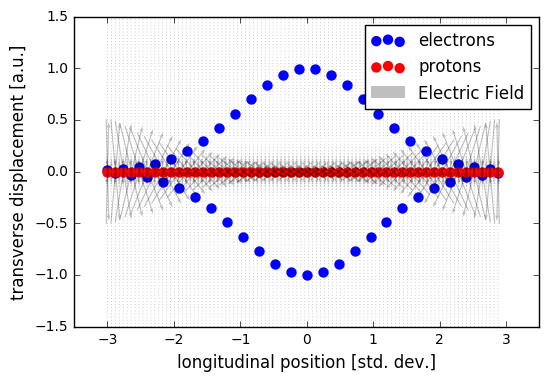

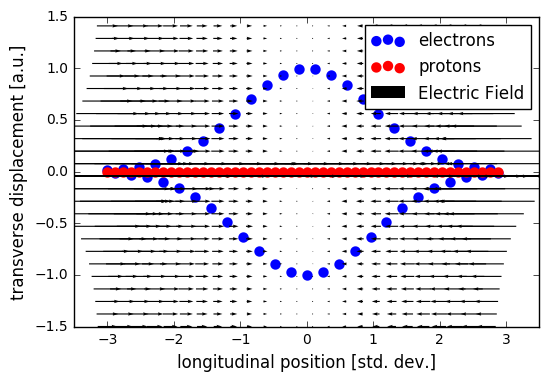

In [67]:
plot(FX,FY,XX,YY,xvec,yvec)